<a href="https://colab.research.google.com/github/boneeyah/QTW/blob/main/Case%20Study%203/Case_Study_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install beautifulsoup4
!pip install scikit-learn-intelex

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls -l /content/drive/MyDrive/SpamAssassinMessages/

total 20
drwx------ 2 root root 4096 Jun  6 01:24 easy_ham
drwx------ 2 root root 4096 Jun  6 01:24 easy_ham_2
drwx------ 2 root root 4096 Jun  6 01:24 hard_ham
drwx------ 2 root root 4096 Jun  6 01:24 spam
drwx------ 2 root root 4096 Jun  6 01:24 spam_2


In [ ]:
from gensim.parsing.preprocessing import STOPWORDS
from nltk import word_tokenize
import os, chardet, email
import pandas as pd 
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from bs4 import BeautifulSoup
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report
from nltk.corpus import stopwords
import nltk; nltk.download('popular')

In [ ]:
file_list = []
for root, dirs, files in os.walk("/content/drive/MyDrive/SpamAssassinMessages/", topdown=False):
    for name in files:
        tmp = os.path.join(root,name)
        file_list.append(tmp)
    for item in dirs:
        print(item)
i=0

file_list_full = []
while i < len(file_list):
    file_list_full.append(file_list[i])
    i+=1

spam_2
spam
easy_ham_2
easy_ham
hard_ham


In [ ]:
len(file_list_full)

9353

In [ ]:
headers

In [ ]:
import os
import smtplib
# For guessing MIME type based on file name extension
import mimetypes

from argparse import ArgumentParser

from email.message import EmailMessage
from email.policy import SMTP

parser = ArgumentParser(description="""\
Send the contents of a directory as a MIME message.
Unless the -o option is given, the email is sent by forwarding to your local
SMTP server, which then does the normal delivery process.  Your local machine
must be running an SMTP server.
""")

parser.add_argument('-s', '--sender', required=True,
                        help='The value of the From: header (required)')

headers = Parser(policy=default).parsestr(file_list_full[2])


In [ ]:
print(headers)


/content/drive/MyDrive/SpamAssassinMessages/spam_2/00653.dcb006e0c0aaa7aa3e5bd7cb3d444f23


In [ ]:
%%capture
contents = []
types = []
labels = []
sender = []

i = 0

for root, dirs, files in os.walk("/content/drive/MyDrive/SpamAssassinMessages/"):
    for name in files:
        blob = open(os.path.join(root, name), 'rb').read()

        # Determining the encoding of the email
        result = chardet.detect(blob)
        encoding_dynamic = result['encoding']

        with open(os.path.join(root, name), 'rb') as f:
            decoded_email = f.read().decode(encoding_dynamic, errors='replace')
            
            x = email.message_from_string(decoded_email)
            print('normal', os.path.join(root, name))
            i += 1

            #adding in the sender's domain as a new column
            sender_raw = x.get('From')
            if sender_raw:
                sender_domain = sender_raw.split('@')[-1]
                if sender_domain:
                    sender.append(sender_domain)
                else:
                    sender.append("missing")
            else:
                sender.append("missing")


            if "multipart" in x.get_content_type():
                content_parts = []
                for part in x.walk():
                    if part.get_content_type() == "text/plain":
                        decoded_part = part.get_payload(decode=True).decode(encoding_dynamic, errors='replace')
                        content_parts.append(decoded_part.replace("\n", " "))
                    elif part.get_content_type() == "text/html":
                        soup = BeautifulSoup(part.get_payload(decode=True).decode(encoding_dynamic, errors='replace'), 'html.parser')
                        decoded_part = soup.get_text().replace("\n", " ")
                        content_parts.append(decoded_part)
                content = "\n".join(content_parts)
                contents.append(content)
                types.append(x.get_content_type())

            elif "text/plain" in x.get_content_type():
                decoded_content = x.get_payload(decode=True).decode(encoding_dynamic, errors='replace')
                contents.append(decoded_content.replace("\n", " "))
                types.append(x.get_content_type())

            elif "text/html" in x.get_content_type():
                soup = BeautifulSoup(x.get_payload(decode=True).decode(encoding_dynamic, errors='replace'), 'html.parser')
                decoded_content = soup.get_text().replace("\n", " ")
                contents.append(decoded_content)
                types.append(x.get_content_type())

            if "ham" in root:
                labels.append(0)
            elif "spam" in root:
                labels.append(1)
            else:
                print("YOU HAVE A BIG PROBLEM -- LABEL NOT FOUND")


In [ ]:
print('contents length: ', len(contents))
print('types length: ', len(types))
print('labels length: ', len(labels))
print('file list length: ', len(file_list_full))
print('sender length: ', len(sender))

contents length:  9353
types length:  9353
labels length:  9353
file list length:  9353
sender length:  9353


In [ ]:
# Encode the contents array to utf-8, before it gets added to pandas dataframe
encoded_contents = [content.encode('utf-8', errors='replace') for content in contents]

In [ ]:
data = pd.DataFrame({"Text":encoded_contents,"Label":labels, "Type":types, "Filename": file_list_full, "Sender": sender})
data

,Text,Label,Type,Filename,Sender
0,"b""SUBJECT: Urgent Concern ...",1,text/plain,/content/drive/MyDrive/SpamAssassinMessages/sp...,writeme.com>
1,b' \xc2\xa0 You can\'t predic...,1,text/html,/content/drive/MyDrive/SpamAssassinMessages/sp...,personal.ro>
2,"b'As seen on NBC, CBS, CNN, and even Oprah! Th...",1,text/plain,/content/drive/MyDrive/SpamAssassinMessages/sp...,mail.com
3,b' Thanks ...,1,multipart/mixed,/content/drive/MyDrive/SpamAssassinMessages/sp...,dogma.slashnull.org>
4,b' \xc2\xa0 Dear ...,1,text/html,/content/drive/MyDrive/SpamAssassinMessages/sp...,263.net>
...,...,...,...,...,...
9348,"b'Hi XFS developers, When studying xfs code(2....",0,text/plain,/content/drive/MyDrive/SpamAssassinMessages/ha...,mountainviewdata.com>
9349,"b""My gut reaction would be to tell them to go ...",0,text/plain,/content/drive/MyDrive/SpamAssassinMessages/ha...,eircom.net>
9350,b' * WORD A DAY * -------...,0,text/plain,/content/drive/MyDrive/SpamAssassinMessages/ha...,shagmail.com>
9351,"b""============================================...",0,text/plain,/content/drive/MyDrive/SpamAssassinMessages/ha...,daytips.com>


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9353 entries, 0 to 9352
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      9353 non-null   object
 1   Label     9353 non-null   int64 
 2   Type      9353 non-null   object
 3   Filename  9353 non-null   object
 4   Sender    9353 non-null   object
dtypes: int64(1), object(4)
memory usage: 365.5+ KB


In [ ]:
data['Text'] = data['Text'].astype('|S') # which will by default set the length to the max len it encounters
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9353 entries, 0 to 9352
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Text      9353 non-null   |S202500
 1   Label     9353 non-null   int64   
 2   Type      9353 non-null   object  
 3   Filename  9353 non-null   object  
 4   Sender    9353 non-null   object  
dtypes: bytes1620000(1), int64(1), object(3)
memory usage: 1.8+ GB


In [ ]:
data['Label'].value_counts() #distribution of spam/ham

0    6954
1    2399
Name: Label, dtype: int64

In [ ]:
stop = list(stopwords.words('english'))
#to add additional words to stop words
#stop.extend('myword1 myword2 myword3'.split())

# MultiNB
X = data['Text']
y = data['Label'].values

skf = StratifiedKFold(n_splits=10,random_state=610,shuffle=True)
skf.get_n_splits(X,y)

#need to vectorize within pipeline to prevent data leakage (otherwise tfidf would be fitted over all the data)
my_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=stop, ngram_range=(2,2), analyzer='word')),
    ('estimator',MultinomialNB())
])
pipe_params = {
    'estimator__alpha':[.01,.05,.1]
}

grid = GridSearchCV(my_pipe,pipe_params,cv=skf,scoring='accuracy',n_jobs=-1)
results = grid.fit(X,y)
print(results.best_estimator_)
print(results.best_score_)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(2, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 token_pattern='(?u)\\b\\w+\\b')),
                ('estimator', MultinomialNB(alpha=0.01))])
0.9928367384249738


In [ ]:
results_df=pd.DataFrame(results.cv_results_)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,13.804213,0.856264,1.044800,0.245110,0.01,{'estimator__alpha': 0.01},0.995726,0.990385,0.990385,0.996791,0.990374,0.989305,0.995722,0.994652,0.992513,0.992513,0.992837,0.002577,1
1,14.245896,1.436944,1.059985,0.203623,0.05,{'estimator__alpha': 0.05},0.991453,0.988248,0.983974,0.997861,0.989305,0.989305,0.990374,0.991444,0.993583,0.989305,0.990485,0.003427,2
2,12.687541,1.807287,0.836019,0.152526,0.1,{'estimator__alpha': 0.1},0.989316,0.986111,0.980769,0.996791,0.983957,0.982888,0.988235,0.990374,0.991444,0.987166,0.987705,0.004413,3


In [ ]:
# MultiNB with best params
my_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=stop, ngram_range=(2,2), analyzer='word')),
    ('estimator',MultinomialNB(alpha=results.best_params_.get('estimator__alpha')))
])
acc_score = []
rec_score = []
feature_names = []

for i, (train,test) in enumerate(skf.split(X,y)):
    my_pipe.fit(X[train],y[train])
    p = my_pipe.predict(X[test])
    acc_score.append(accuracy_score(y[test],p))
    rec_score.append(recall_score(y[test],p))
    print(classification_report(y[test],p))

    #feature importance by word
    feature_log_probs = my_pipe.named_steps['estimator'].feature_log_prob_
    feature_names = my_pipe.named_steps['vectorizer'].get_feature_names_out()


# Convert feature log probabilities to probabilities
feature_probs = np.exp(feature_log_probs)

# Create a DataFrame to store feature importance
feature_importance = pd.DataFrame({'Feature': feature_names,
                                   'Importance': feature_probs[1]})

# Sort feature importance by importance score
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)


# saving scores for comparison    
mNB_scores = pd.DataFrame({'accuracy':acc_score,
                           'recall':rec_score})


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       696
           1       1.00      0.99      0.99       240

    accuracy                           1.00       936
   macro avg       1.00      0.99      0.99       936
weighted avg       1.00      1.00      1.00       936

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       696
           1       0.99      0.97      0.98       240

    accuracy                           0.99       936
   macro avg       0.99      0.99      0.99       936
weighted avg       0.99      0.99      0.99       936

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       696
           1       0.99      0.97      0.98       240

    accuracy                           0.99       936
   macro avg       0.99      0.98      0.99       936
weighted avg       0.99      0.99      0.99       936

              preci

In [ ]:
feature_importance

,Feature,Importance
249693,http www,9.580228e-04
175683,e mail,9.549913e-04
451745,spamassassin sightings,7.982697e-04
372593,please click,6.993440e-04
182390,email address,5.408017e-04
...,...,...
239724,hebrew words,3.507387e-07
239723,hebrew word,3.507387e-07
239722,hebrew traditional,3.507387e-07
239721,hebrew steal,3.507387e-07


In [ ]:
mNB_scores

,accuracy,recall
0,0.994658,0.987500
1,0.994658,0.991667
2,0.988248,0.962500
3,0.991444,0.970711
4,0.983957,0.945833
5,0.990374,0.970833
6,0.988235,0.958333
7,0.993583,0.983333
8,0.989305,0.970833
9,0.996791,0.987500


In [ ]:
# support vector machine - classifier
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.svm import SVC

my_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(2,2), analyzer='word')),
    ('estimator',SVC(random_state=610))
])
pipe_params = {
    'estimator__C':[.01,.1,.5,1],
    'estimator__gamma':['scale','auto']
}

grid = GridSearchCV(my_pipe,pipe_params,cv=skf,scoring='accuracy',n_jobs=-1)
results = grid.fit(X,y)
print(results.best_estimator_)
print(results.best_score_)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(2, 2),
                                 token_pattern='(?u)\\b\\w+\\b')),
                ('estimator', SVC(C=1, random_state=610))])
0.9868491475844416


In [ ]:
# svc with best params
my_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(2,2), analyzer='word')),
    ('estimator',SVC(random_state=610,C=results.best_params_.get('estimator__C')))#not returning best for gamma for some reason
])
acc_score = []
rec_score = []
for i, (train,test) in enumerate(skf.split(X,y)):
    my_pipe.fit(X[train],y[train])
    p = my_pipe.predict(X[test])
    acc_score.append(accuracy_score(y[test],p))
    rec_score.append(recall_score(y[test],p))
    print(classification_report(y[test],p))
    
svc_scores = pd.DataFrame({'accuracy':acc_score,
                           'recall':rec_score})

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       696
           1       1.00      0.96      0.98       240

    accuracy                           0.99       936
   macro avg       0.99      0.98      0.98       936
weighted avg       0.99      0.99      0.99       936

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       696
           1       0.99      0.95      0.97       240

    accuracy                           0.99       936
   macro avg       0.99      0.97      0.98       936
weighted avg       0.99      0.99      0.98       936

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       696
           1       0.99      0.96      0.97       240

    accuracy                           0.99       936
   macro avg       0.99      0.98      0.98       936
weighted avg       0.99      0.99      0.99       936

              preci

In [ ]:
# random forest classifier
from sklearn.ensemble import RandomForestClassifier


my_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(2,2), analyzer='word')),
    ('estimator',RandomForestClassifier(random_state=610,max_depth = 100))
])
pipe_params = {
    'estimator__n_estimators':[50,100,200],
    'estimator__class_weight':['balanced',None]
}

grid = GridSearchCV(my_pipe,pipe_params,cv=skf,scoring='accuracy',n_jobs=-1)
results = grid.fit(X,y)
print(results.best_estimator_)
print(results.best_score_)

In [ ]:
# rf best params
my_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(2,2), analyzer='word')),
    ('estimator',RandomForestClassifier(max_detph = 100,
                                        random_state=610,
                                        n_estimators = results.best_params.get('n_estimators'),
                                        class_weight = results.best_params.get('class_weight')))
])
acc_score = []
rec_score = []
for i, (train,test) in enumerate(skf.split(X,y)):
    my_pipe.fit(X[train],y[train])
    p = my_pipe.predict(X[test])
    acc_score.append(accuracy_score(y[test],p))
    rec_score.append(recall_score(y[test],p))
    print(classification_report(y[test],p))
    
rf_scores = pd.DataFrame({'accuracy':acc_score,
                           'recall':rec_score})

In [ ]:
# clustering
## checking to see if KMeans can find two clusters that match fairly well with target

from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=2,n_init='auto',random_state=610).fit(X)
km_labels = clustering.labels_


In [91]:
for i in np.unique(km_labels):
  count = len(km_labels[db_labels==i])
  print(i,count)

0 7109
1 6


In [ ]:
# clustering
from sklearn.cluster import DBSCAN #DBSCAN works with

clustering = DBSCAN(eps=1,n_jobs=-1).fit(X)
db_labels = clustering.labels_

In [90]:
for i in np.unique(db_labels):
  count = len(db_labels[db_labels==i])
  print(i,count)

-1 2182
0 7109
1 6
2 5
3 6
4 5
5 8
6 5
7 5
8 8
9 6
10 8


In [102]:
scores_df = pd.concat([mNB_scores.assign(Model = "MultiNB",Fold = mNB_scores.index),
                                 svc_scores.assign(Model = "SVC", Fold = svc_scores.index),
                                 rf_scores.assign(Model = "RandomForest", Fold = rf_scores.index)
                                 ])

<Axes: xlabel='Model', ylabel='value'>

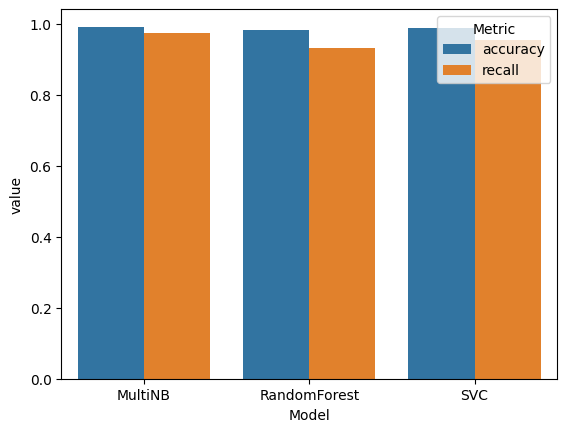

In [122]:
import seaborn as sns
scores_mean = scores_df.groupby('Model',as_index=False).agg('mean')
scores_mean = scores_mean.melt(id_vars=["Model"],value_vars=['accuracy','recall'],var_name='Metric')
sns.barplot(data = scores_mean,y="value",x='Model',hue='Metric')

In [104]:

scores_df.melt(id_vars=["Model",'Fold'],value_vars=['accuracy','recall'],value_name='Metric')

,Model,Fold,variable,Metric
0,MultiNB,0,accuracy,0.994658
1,MultiNB,1,accuracy,0.994658
2,MultiNB,2,accuracy,0.988248
3,MultiNB,3,accuracy,0.991444
4,MultiNB,4,accuracy,0.983957
5,MultiNB,5,accuracy,0.990374
6,MultiNB,6,accuracy,0.988235
7,MultiNB,7,accuracy,0.993583
8,MultiNB,8,accuracy,0.989305
9,MultiNB,9,accuracy,0.996791


In [100]:
import seaborn as sns
sns.barplot(scores_df,x=)

,accuracy,recall,Model
0,0.994658,0.987500,MultiNB
1,0.994658,0.991667,MultiNB
2,0.988248,0.962500,MultiNB
3,0.991444,0.970711,MultiNB
4,0.983957,0.945833,MultiNB
5,0.990374,0.970833,MultiNB
6,0.988235,0.958333,MultiNB
7,0.993583,0.983333,MultiNB
8,0.989305,0.970833,MultiNB
9,0.996791,0.987500,MultiNB


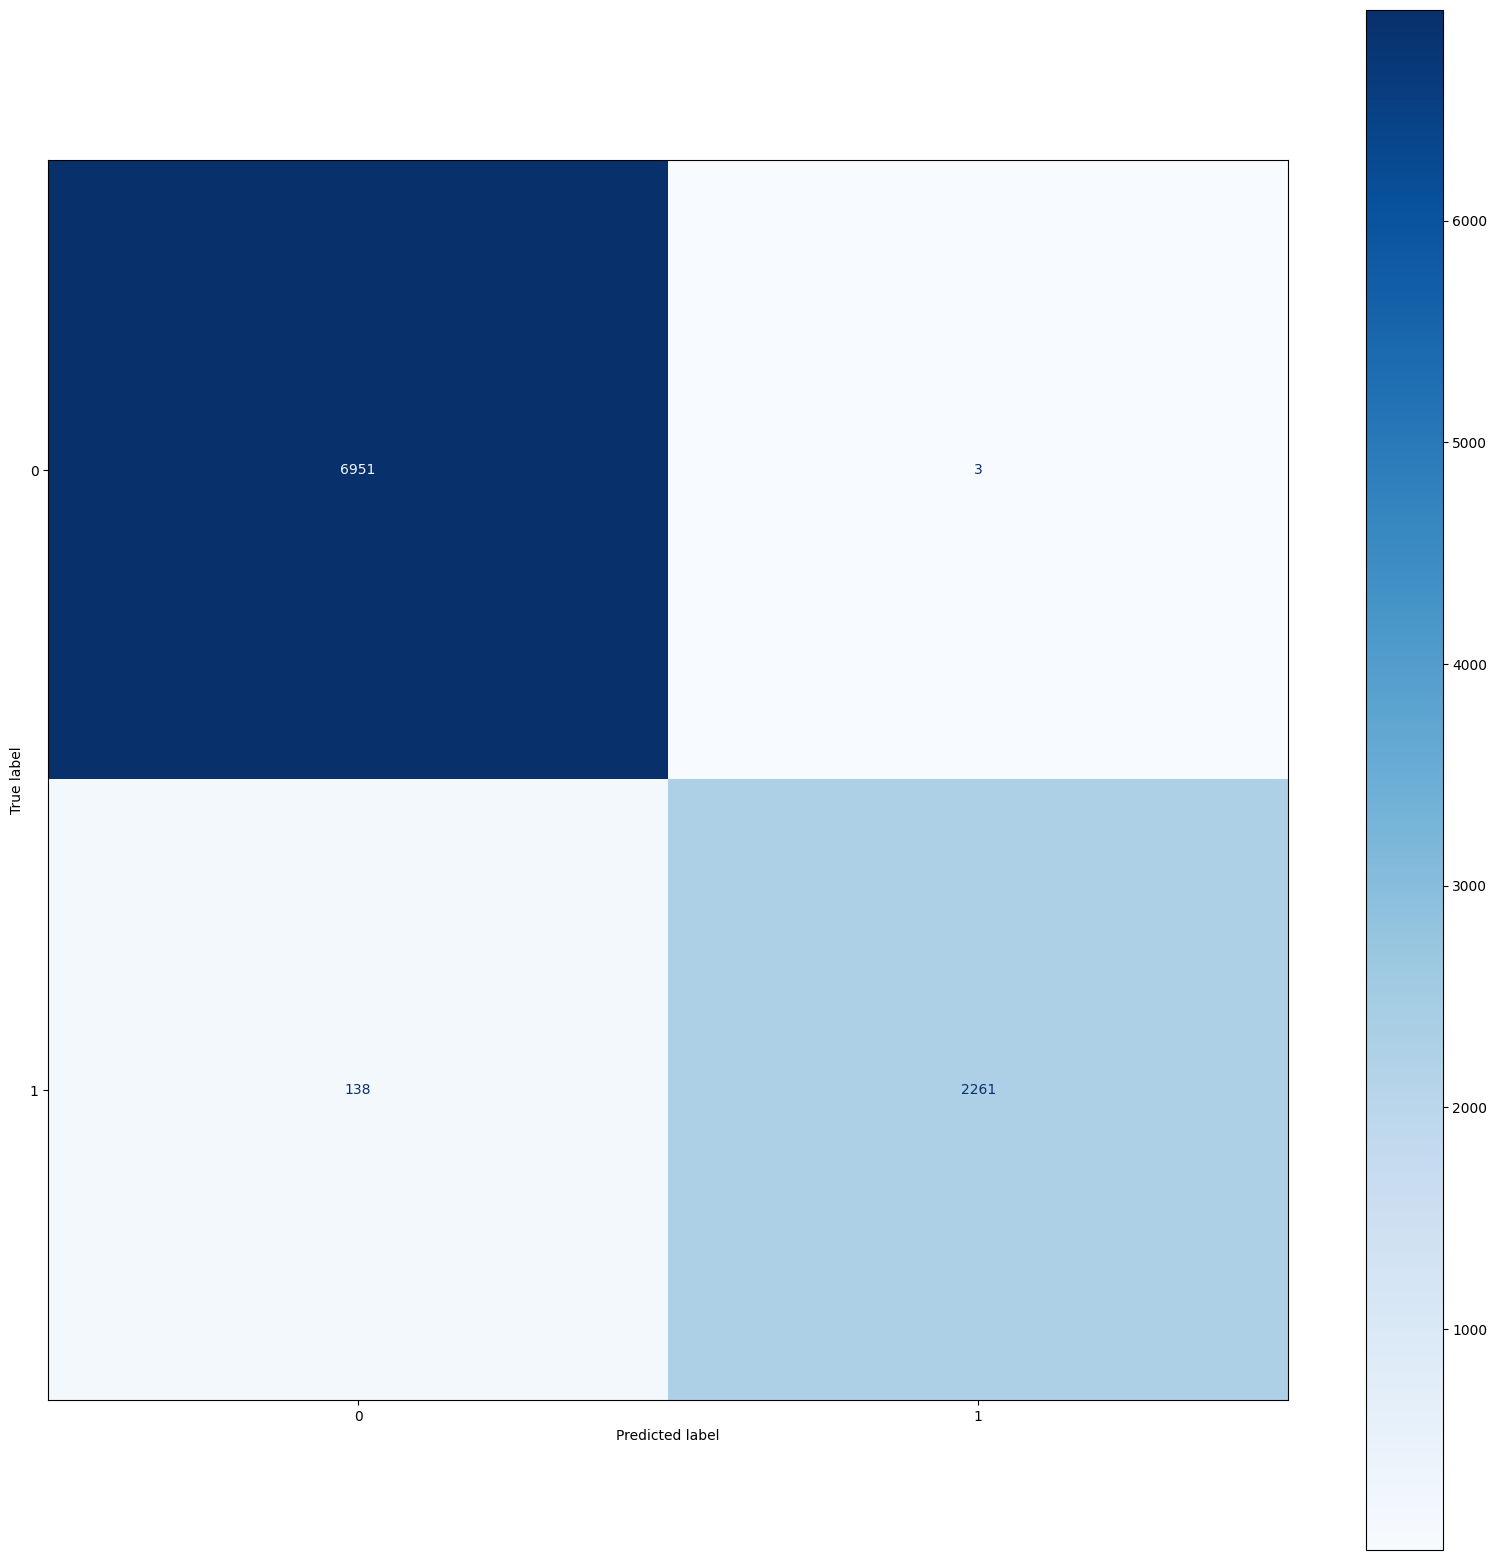

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)
ConfusionMatrixDisplay.from_predictions(target['Label'],p,cmap='Blues')

In [ ]:
reverse={}
for word,value in word_counts.vocabulary_.items():
    reverse[value]=word